In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [115]:
# Load the data
df = pd.read_csv('data/financial_data.csv')

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract year, month, and day if not already extracted
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [116]:
df.head()

,revenue,expenses,profit,year,month,day,company,date
0,1332,727,605,2024,9,10,xyz,2024-09-10
1,6131,2903,3228,2024,9,11,xyz,2024-09-11
2,4042,4617,-575,2024,9,12,xyz,2024-09-12
3,8291,6376,1915,2024,9,13,xyz,2024-09-13
4,6767,8895,-2128,2024,9,14,xyz,2024-09-14


In [117]:
# Data Cleaning
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
revenue     0
expenses    0
profit      0
year        0
month       0
day         0
company     0
date        0
dtype: int64


In [118]:
# Handle missing values (e.g., forward fill)
df.fillna(method='ffill', inplace=True)

/tmp/ipykernel_8167/689163886.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [119]:
# Check for duplicates and remove them
df.drop_duplicates(inplace=True)

In [120]:
# Verify the relationship: revenue - expenses = profit
assert (df['revenue'] - df['expenses']).equals(df['profit']), "Revenue minus expenses does not equal profit"

In [121]:
# EDA - Descriptive Statistics
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
            revenue      expenses        profit          year         month  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    5487.677600   5212.727900    274.949700   2037.878200      6.555300   
min     1002.000000    501.000000  -8781.000000   2024.000000      1.000000   
25%     3231.750000   2886.500000  -2408.250000   2031.000000      4.000000   
50%     5500.500000   5204.500000    240.000000   2038.000000      7.000000   
75%     7749.000000   7557.000000   2982.250000   2045.000000     10.000000   
max    10000.000000  10000.000000   9310.000000   2052.000000     12.000000   
std     2600.919351   2714.868615   3746.387308      7.907643      3.465623   

               day                 date  
count  10000.00000                10000  
mean      15.73280  2038-05-19 12:00:00  
min        1.00000  2024-09-10 00:00:00  
25%        8.00000  2031-07-15 18:00:00  
50%       16.00000  2038-05-19 12:00:00  
75%       2

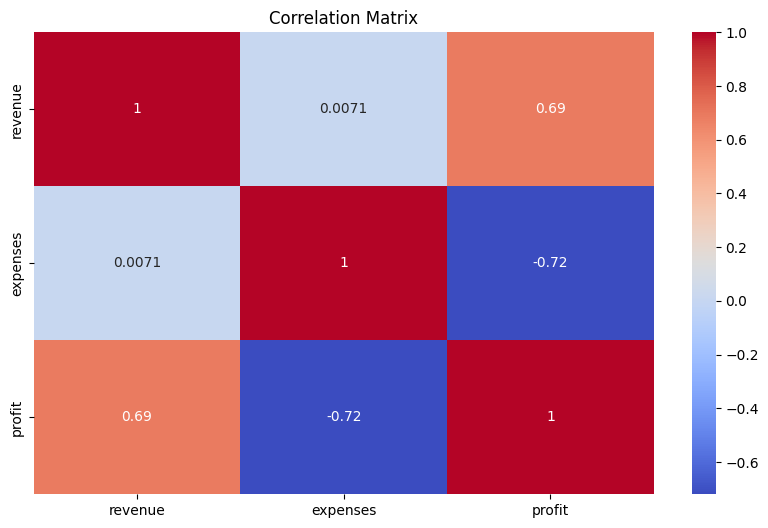

In [122]:
# EDA - Correlation Analysis
plt.figure(figsize=(10, 6))
sns.heatmap(df[['revenue', 'expenses', 'profit']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

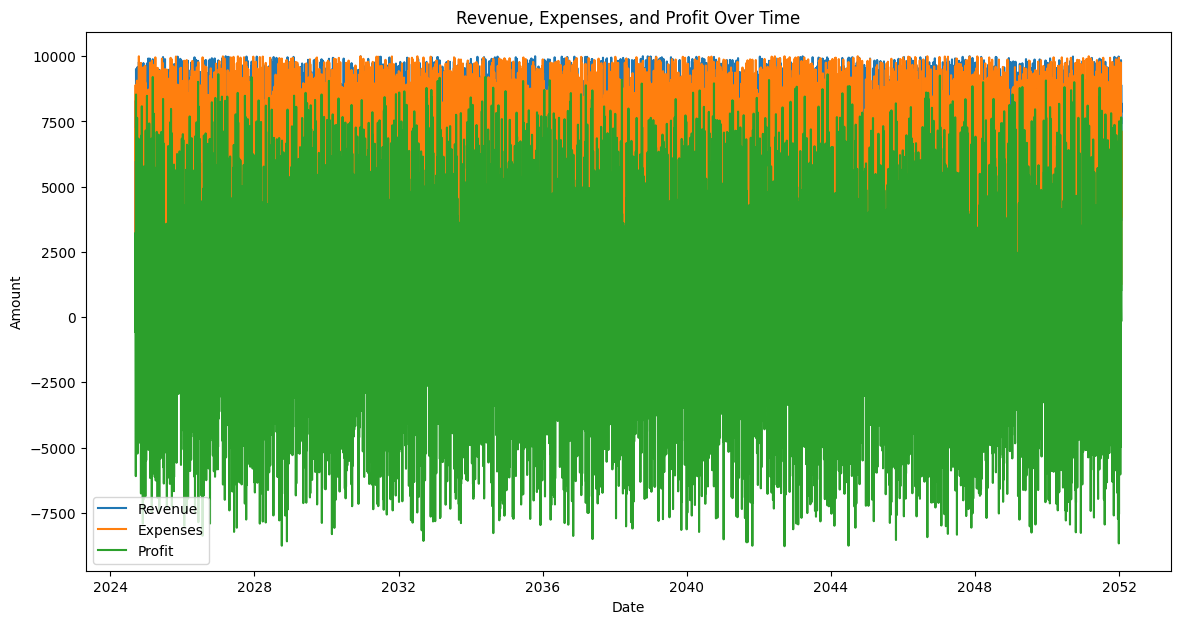

In [123]:
# EDA - Visualizing Time Series Trends
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['revenue'], label='Revenue')
plt.plot(df['date'], df['expenses'], label='Expenses')
plt.plot(df['date'], df['profit'], label='Profit')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Revenue, Expenses, and Profit Over Time')
plt.legend()
plt.show()

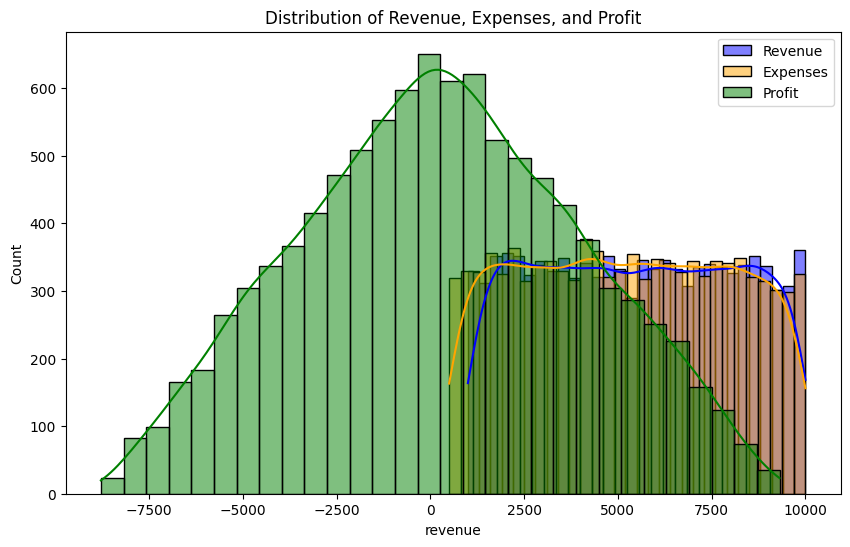

In [124]:
# EDA - Distribution Analysis
plt.figure(figsize=(10, 6))
sns.histplot(df['revenue'], bins=30, kde=True, color='blue', label='Revenue')
sns.histplot(df['expenses'], bins=30, kde=True, color='orange', label='Expenses')
sns.histplot(df['profit'], bins=30, kde=True, color='green', label='Profit')
plt.title('Distribution of Revenue, Expenses, and Profit')
plt.legend()
plt.show()

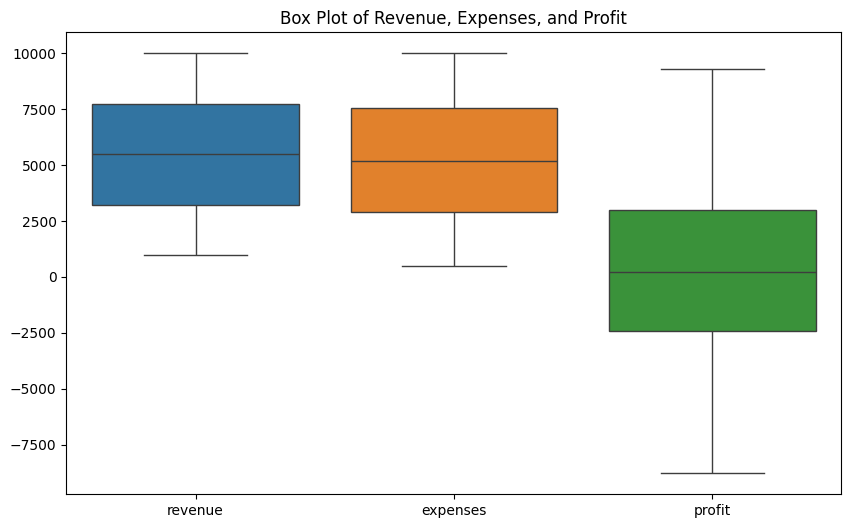

In [125]:
# EDA - Box Plots for Outlier Detection
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['revenue', 'expenses', 'profit']])
plt.title('Box Plot of Revenue, Expenses, and Profit')
plt.show()

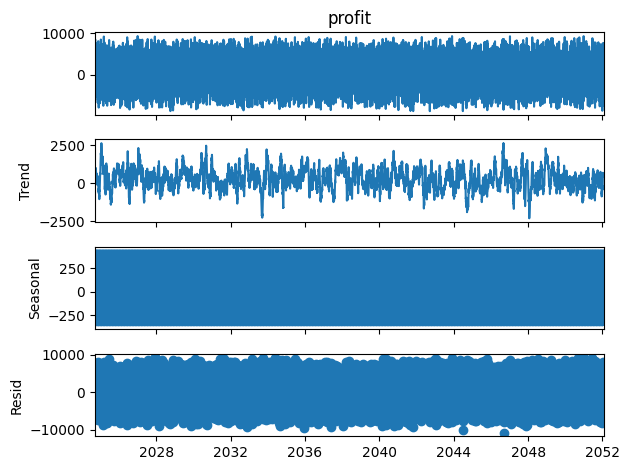

In [126]:
# EDA - Time Series Decomposition
decompose_result = seasonal_decompose(df.set_index('date')['profit'], model='additive', period=30)
decompose_result.plot()
plt.show()

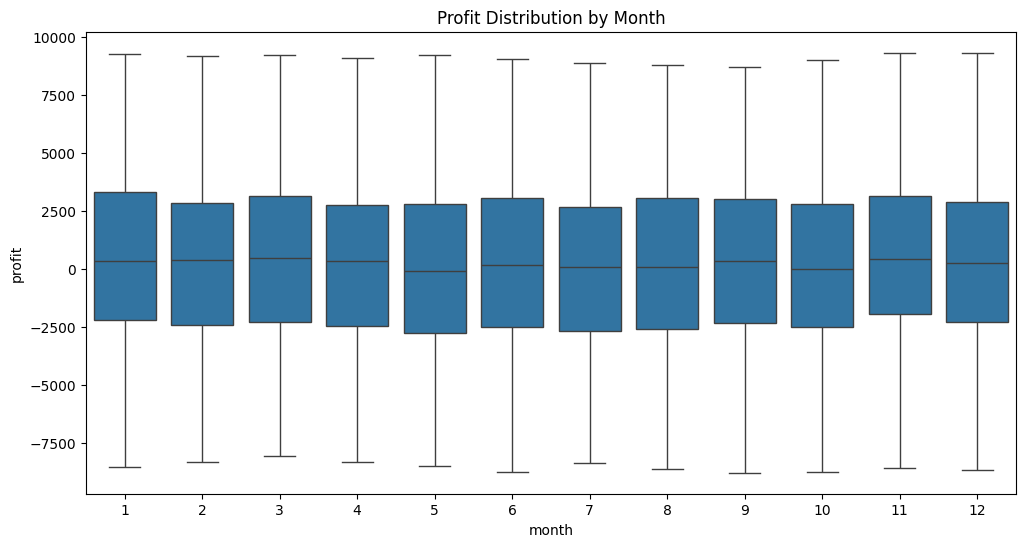

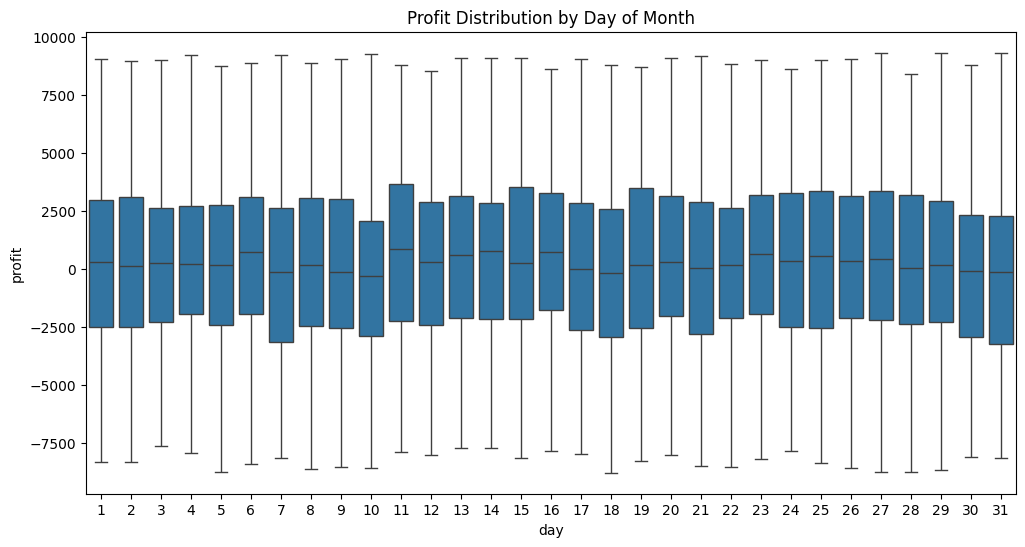

In [127]:
# EDA - Seasonal Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='profit', data=df)
plt.title('Profit Distribution by Month')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='day', y='profit', data=df)
plt.title('Profit Distribution by Day of Month')
plt.show()

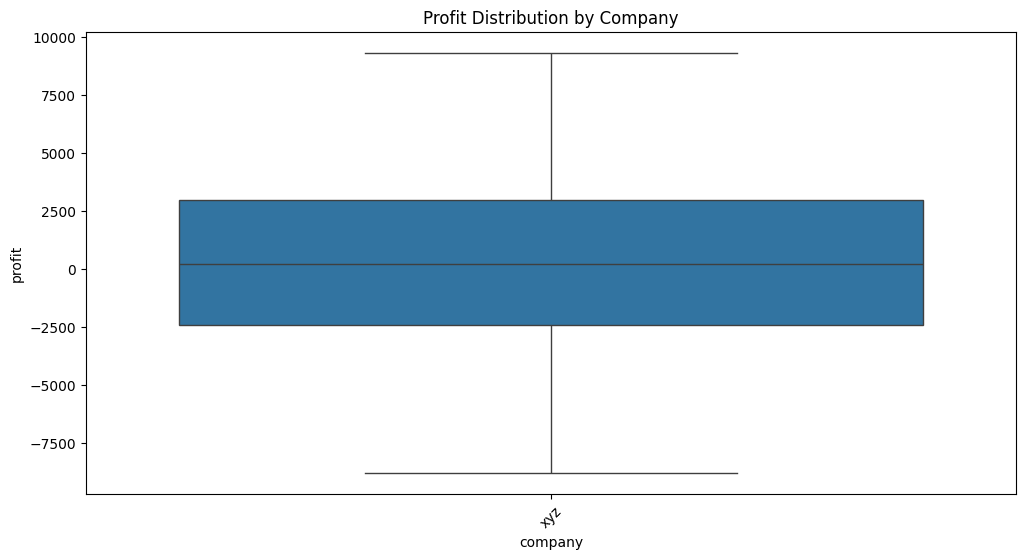

In [128]:
# EDA - Company-Wise Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='company', y='profit', data=df)
plt.title('Profit Distribution by Company')
plt.xticks(rotation=45)
plt.show()

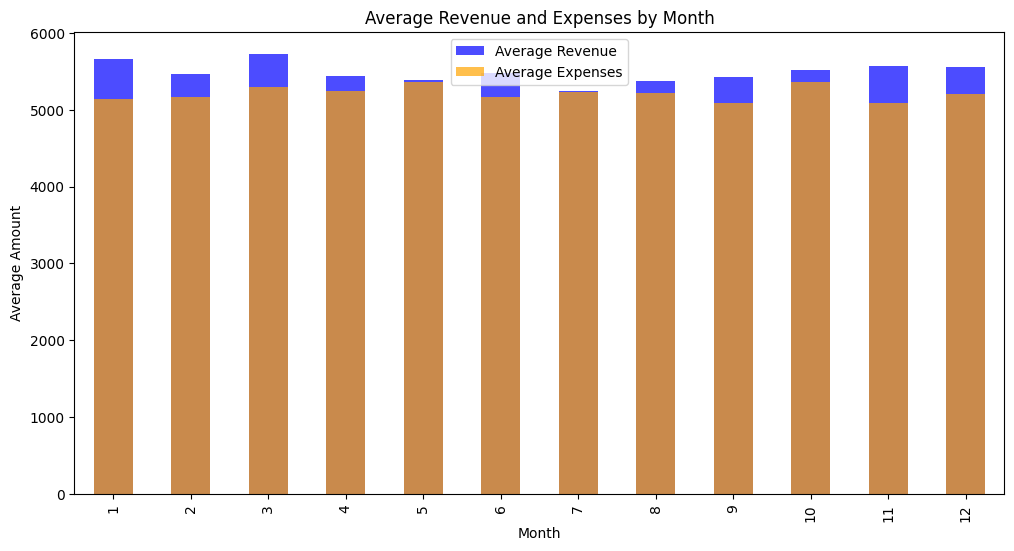

In [129]:
# EDA - Revenue and Expense Trends by Month
plt.figure(figsize=(12, 6))
df.groupby('month')['revenue'].mean().plot(kind='bar', color='blue', alpha=0.7, label='Average Revenue')
df.groupby('month')['expenses'].mean().plot(kind='bar', color='orange', alpha=0.7, label='Average Expenses')
plt.title('Average Revenue and Expenses by Month')
plt.xlabel('Month')
plt.ylabel('Average Amount')
plt.legend()
plt.show()

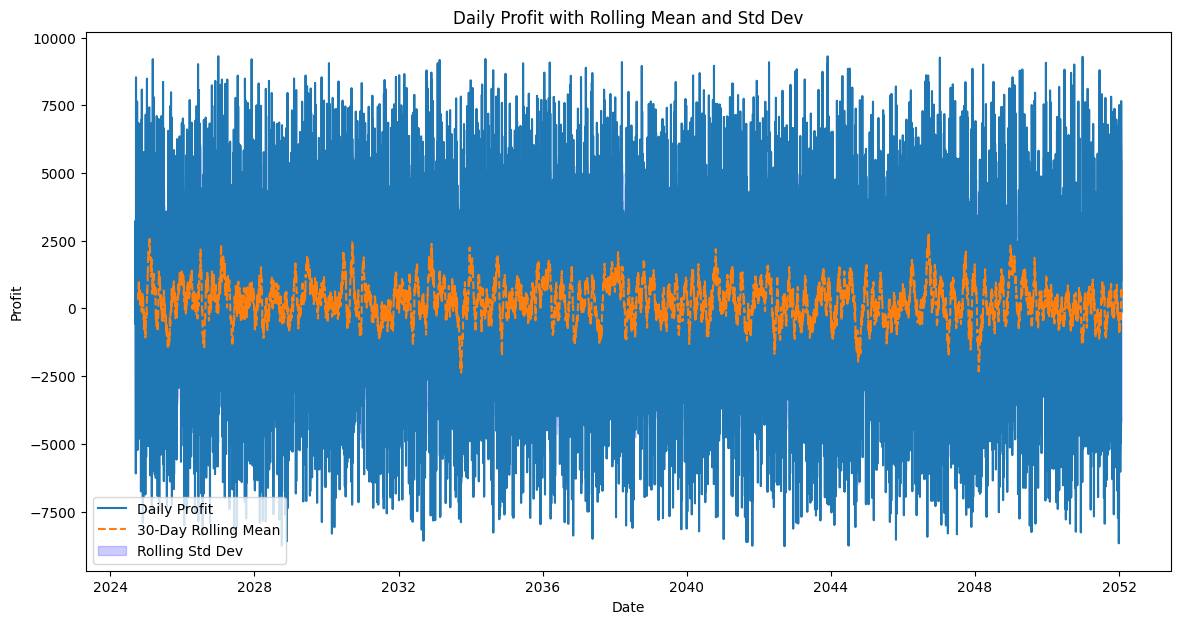

In [130]:

# EDA - Rolling Mean and Standard Deviation
rolling_window = 30  # 30 days rolling window
df['rolling_profit_mean'] = df['profit'].rolling(window=rolling_window).mean()
df['rolling_profit_std'] = df['profit'].rolling(window=rolling_window).std()

plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['profit'], label='Daily Profit')
plt.plot(df['date'], df['rolling_profit_mean'], label='30-Day Rolling Mean', linestyle='--')
plt.fill_between(df['date'], df['rolling_profit_mean'] - df['rolling_profit_std'], 
                 df['rolling_profit_mean'] + df['rolling_profit_std'], color='b', alpha=0.2, label='Rolling Std Dev')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.title('Daily Profit with Rolling Mean and Std Dev')
plt.legend()
plt.show()

In [131]:
# Prepare Data for Forecasting
df.set_index('date', inplace=True)
df_daily = df.resample('D').mean(numeric_only=True).ffill()  # Resample to daily frequency and forward-fill missing values


In [132]:


# Feature Engineering - Lagged Features
for lag in range(1, 8):  # Adding lag features for the last 7 days
    df_daily[f'profit_lag_{lag}'] = df_daily['profit'].shift(lag)
    df_daily[f'revenue_lag_{lag}'] = df_daily['revenue'].shift(lag)
    df_daily[f'expenses_lag_{lag}'] = df_daily['expenses'].shift(lag)

In [133]:
df_daily.dropna(inplace=True)  # Remove rows with missing values after lagging


In [134]:
# Split the data into training and testing sets
X = df_daily.drop(columns=['profit'])
y = df_daily['profit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:

# Train a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

In [109]:

# Make predictions
y_pred = model.predict(X_test)

In [110]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 4349.39
R-squared: 1.00


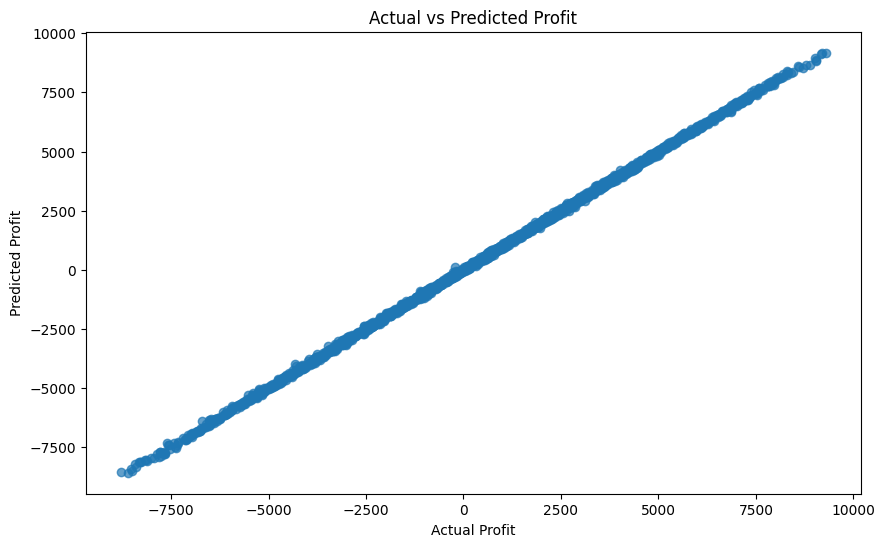

In [111]:

# Plot actual vs predicted profit
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.title('Actual vs Predicted Profit')
plt.show()

In [112]:
# Forecasting future values using ARIMA model for daily prediction
model_arima = ARIMA(df_daily['profit'], order=(5, 1, 0))  # ARIMA model with parameters (p, d, q)
model_arima_fit = model_arima.fit()
forecast = model_arima_fit.forecast(steps=30)

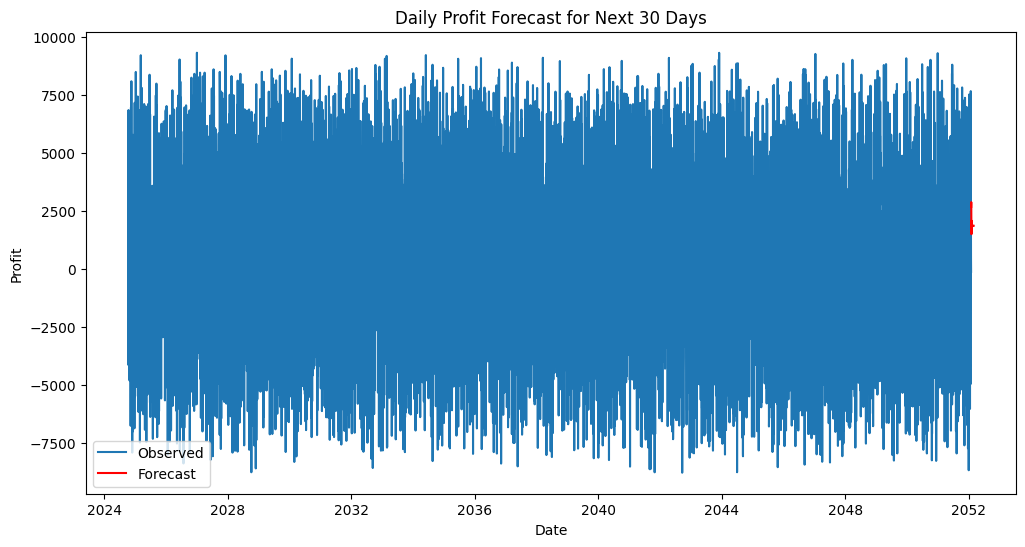

ARIMA Model Forecast:
2052-01-27    2668.028106
2052-01-28    2874.659423
2052-01-29    2052.108875
2052-01-30    1493.383916
2052-01-31    1565.438443
2052-02-01    1778.752769
2052-02-02    2071.647587
2052-02-03    1964.474690
2052-02-04    1816.019857
2052-02-05    1783.413912
2052-02-06    1832.173559
2052-02-07    1876.617338
2052-02-08    1889.449842
2052-02-09    1859.028909
2052-02-10    1842.628177
2052-02-11    1847.789490
2052-02-12    1858.313640
2052-02-13    1862.338442
2052-02-14    1859.629339
2052-02-15    1854.831078
2052-02-16    1854.327080
2052-02-17    1856.305454
2052-02-18    1857.646477
2052-02-19    1857.478947
2052-02-20    1856.661998
2052-02-21    1856.209584
2052-02-22    1856.458464
2052-02-23    1856.804149
2052-02-24    1856.872687
2052-02-25    1856.739839
Freq: D, Name: predicted_mean, dtype: float64


In [113]:

plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['profit'], label='Observed')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title('Daily Profit Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()

print('ARIMA Model Forecast:')
print(forecast)
